# Cvičení 3: bayesovský přístup k vyhledávání havarovaného letadla

**Motivace:** Letadlo se zřítilo do moře. Nevíme, kde, ale máme:

- poslední známou polohu (zvolíme ji jako $(0,0)$) v čase poslední kontroly $t=0$,
- (přibližně) konstantní rychlost letu $V = 800\,\mathrm{km/h}$,
- několik pozdějších nálezů trosek.

V **Cvičení 2** jsme uměli řešit dopřednou úlohu: z daného startu a parametrů spočítat **drift** v čase ve vektorovém poli $\mathbf{w}(\mathbf{r},t)$.

V tomto cvičení uděláme opačný krok: z pozorovaných trosek budeme **odhadovat místo havárie**.

---

## Cíle cvičení
- Fáze 1: aplikovat simulaci unášené trosky z druhého cvičení.
- Fáze 2: rozlišit **priorní rozdělení (prior)**, **věrohodnost (likelihood)** a **posteriorní rozdělení (posterior)** a použít Bayesův vzorec.
- Spočítat hustoty pravděpodobnosti (PDF) pro uniformní a normální rozdělení v 1D i 2D.
- Sestavit jednoduchý **model** s gaussovským šumem.
- Spočítat **posteriorní rozdělení na mřížce** – pravděpodobnostní mapu místa havárie.

---

## Notace a jednotky

- Neznámá poloha havárie: $u=(x,y)$ (v kódu **metry**).
- Pozorování: $y$ (nalezená poloha trosky, v kódu **metry**).
- Dopředný model (drift): $y \approx G(u)$.
- Bayesův vzorec:
  $$\large
  f_{U\mid Y}(u\mid y) \propto f_{Y\mid U}(y\mid u)\, f_U(u).
  $$

V kódu počítáme v **metrech a sekundách**, ale na grafech často přepočítáme na kilometry a hodiny.





---





# První část cvičení - dopředná úloha

## 1.0. Dopředný model driftu (black box)

V souboru `cv3_utils.py` používáme funkci **`simulate_drag_w_synthetic(...)`** (převzatou a zrychlenou z CV2).

Budeme ji brát jako **black box**:

- vstup:
  - `r0` – kandidátní místo havárie $u=(x,y)$ v **metrech** (např. `np.array([x0, y0])`),
  - `t0` – čas havárie v **sekundách** od poslední kontroly,
  - `kappa` – parametr odporu trosky $[\mathrm{m}^{-1}]$,
  - `T` – doba driftu v **sekundách** (čas od havárie do nálezu),
- výstup:
  - `t` – časy [s], `r` – poloha [m], `v` – rychlost [m/s], `a` – zrychlení [m/s²].

V notebooku většinou potřebujeme jen **finální polohu** `r[-1]`.

V souboru `cv3_utils.py` máme také pomocné funkce **`make_grid(...)`**, **`show_map(...)`** a **`show_like_post(...)`**.

Budeme je brát jako pomocné nástroje:

- `make_grid(L, n)`:
  - vstup:
    - `L` – polovina strany oblasti v **metrech**,
    - `n` – počet bodů na každé ose,
  - výstup:
    - `xg`, `yg` – 1D souřadnice mřížky,
    - `XX`, `YY` – 2D meshgrid v **metrech**.

- `show_map(data, xg, yg, title, cbar_label, vmin=None, vmax=None)`:
  - vstup:
    - `data` – hodnoty na mřížce (tvar `(ny, nx)`),
    - `xg`, `yg` – 1D souřadnice mřížky v **metrech**,
    - `title`, `cbar_label` – popisky grafu,
    - `vmin`, `vmax` – volitelné limity barevné škály,
  - výstup:
    - vykreslí 2D mapu s colorbarem.

- `show_like_post(like_data, post_data, xg, yg, title_like, title_post, u_true, u_map)`:
  - vstup:
    - `like_data`, `post_data` – hodnoty na mřížce (tvar `(ny, nx)`),
    - `xg`, `yg` – 1D souřadnice mřížky v **metrech**,
    - `title_like`, `title_post` – popisky grafů,
    - `u_true`, `u_map` – body v **metrech**,
  - výstup:
    - vykreslí dvojici map (věrohodnost a posteriorní rozdělení) bez colorbarů a s body `u_true` a `u_map`.






In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cv3_utils import make_grid, show_map, show_like_post, simulate_drag_w_synthetic

# Základní převody jednotek
HOUR = 3600.0
DAY = 24.0 * HOUR

# Rychlost letadla
V_KMH = 800.0
V = V_KMH * 1000.0 / 3600.0  # [m/s]

# Velikost oblasti pro hledání (prior)
L_KM = 100.0
L = L_KM * 1000.0  # [m]


---
## 1.1. Z bodu $(x,y)$ dopočítáme čas havárie

Pokud pro kandidátní bod havárie $u=(x,y)$ předpokládáme přímočarý let konstantní rychlostí $V$,
pak čas havárie od poslední kontroly je

$$
t_{\mathrm{crash}}(x,y) = \frac{\sqrt{x^2+y^2}}{V}.
$$

Tento čas potřebujeme, protože drift trosek začne až v okamžiku havárie.






---
### Úkol 1: Mapa času havárie z $(x,y)$

**Zadání:** Na mřížce $[-L,L]^2$ spočtěte $t_{\mathrm{crash}}(x,y)$ a vykreslete mapu času (např. v hodinách).





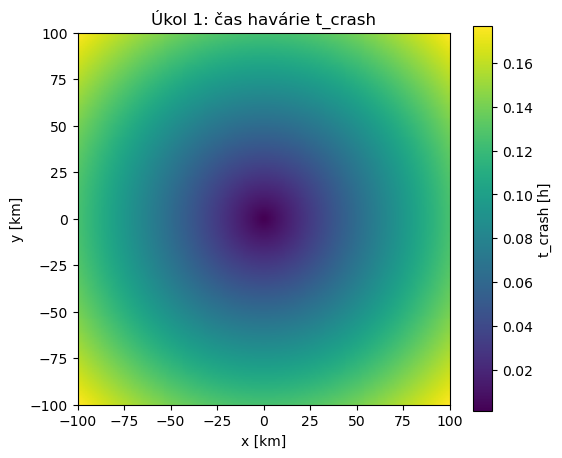

In [2]:
# Úkol 1 – řešení

###### doplňte kód zde ######
grid_n = 160
xg, yg, XX, YY = make_grid(L, grid_n)

t_crash = np.hypot(XX, YY) / V  # [s]
#############################

show_map(t_crash / HOUR, xg, yg, "Úkol 1: čas havárie t_crash", "t_crash [h]")


---
## 1.2. Forward model driftu trosek (black box)

Dopředný model $G(u)$ vezme kandidátní místo havárie $u$ a vrátí (simulovanou) polohu trosky
v čase nálezu.

V této části si ověříme, že umíme solver zavolat a rozumíme vstupům/výstupům.






---
### Úkol 2: Otestujte solver na jednom bodě

**Zadání:** Zvolte jeden kandidátní bod havárie a vykreslete trajektorii.

Parametry:
- $u_0 = (0,\ 0{.}6\,L)$,
- $\kappa = 2{.}0\times 10^{-2}\,\mathrm{m}^{-1}$,
- doba driftu $T = 5$ dní.

Výstup: trajektorie v rovině $(x,y)$ se startem a koncem (v km).





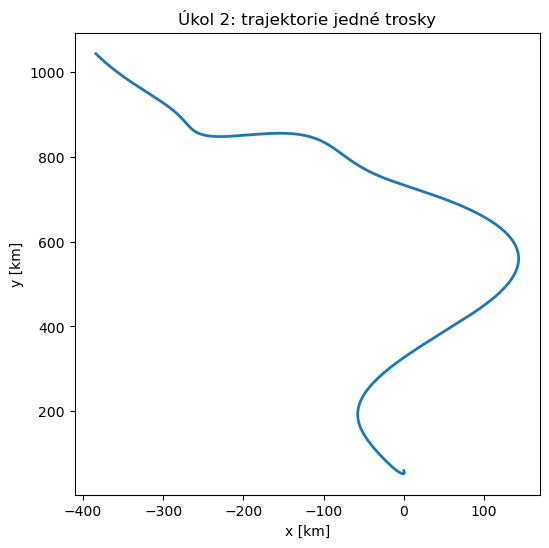

In [3]:
# Úkol 2 – řešení

###### doplňte kód zde ######
u0 = np.array([0.0, 0.6 * L])      # [m]
kappa0 = 2.0e-2                    # [1/m]
T_drift = 5.0 * DAY                # [s]

t0 = np.hypot(u0[0], u0[1]) / V    # [s] čas havárie
t, r, v, a = simulate_drag_w_synthetic(u0, t0, kappa0, T_drift)
#############################

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(r[:, 0] / 1000.0, r[:, 1] / 1000.0, lw=2)
ax.set(xlabel="x [km]", ylabel="y [km]", title="Úkol 2: trajektorie jedné trosky")
plt.show()


---
## 1.3. Dopředný model na mřížce: $G(u)$ pro mnoho kandidátů

Pro Bayesův výpočet na mřížce potřebujeme pro každý kandidátní bod $u=(x,y)$ spočítat předpověď
$G(u)$ – tedy finální polohu trosky v čase nálezu.

To znamená:

1. z bodu $u$ spočítat čas havárie $t_{\mathrm{crash}}(u)$,
2. driftovat po dobu $T_{\mathrm{drift}} = t_{\mathrm{find}} - t_{\mathrm{crash}}$,
3. uložit finální polohu.

Poznámka: I když je samotný solver rychlý (numba), vyhodnocení na celé mřížce může být náročné.
Proto budeme pro posteriorní rozdělení typicky používat menší `GRID_N` (např. 30–60).






---
### Úkol 3: Funkce `forward_grid_final`

**Zadání:** Napište funkci `forward_grid_final`, která pro danou trosku:

- projde mřížku kandidátů $(x,y)$,
- spočte `t_crash` a `T_drift`,
- zavolá `simulate_drag_w_synthetic(...)`,
- uloží finální souřadnice.

Výstup: dvě mapy `X_final`, `Y_final`.

Nejprve funkci otestujte na jedné trosce s parametry:

| kappa [1/m] | t_find_h [h] | y_obs_km (x, y) |
| ---: | ---: | --- |
| 0.000232 | 24  | (5, 259) |

a vykreslete mapy `x_final`, `y_final` (v km).






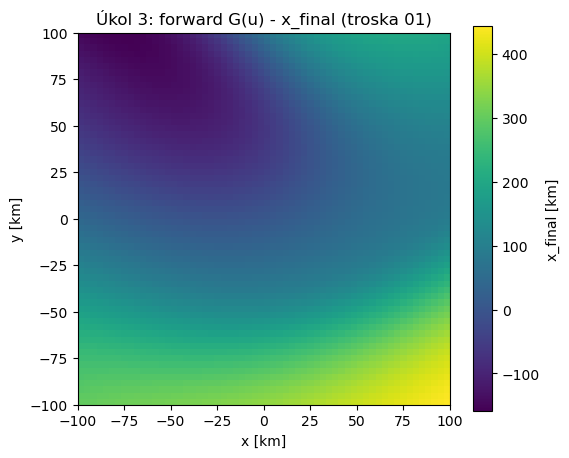

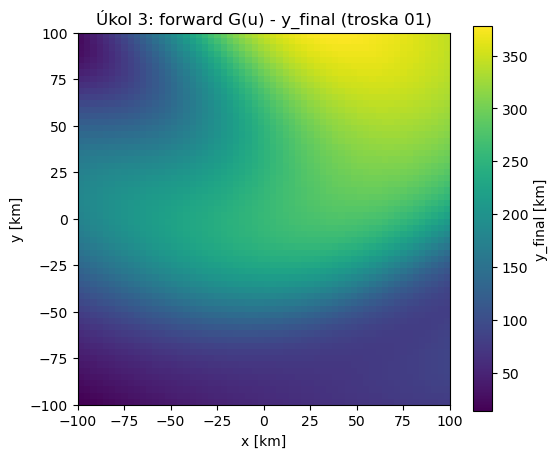

In [4]:
# Úkol 3 – řešení

def forward_grid_final(XX, YY, t_crash, t_find, kappa):
    """Pro každý bod mřížky spočte finální polohu trosky v čase t_find.

    Parametry
    ---------
    XX, YY : 2D arrays
        Souřadnice mřížky (v metrech).
    t_crash : 2D array
        Čas havárie pro každý bod mřížky (v sekundách).
    t_find : float
        Čas nálezu (v sekundách od poslední kontroly).
    kappa : float
        Parametr odporu trosky [1/m].

    Návrat
    ------
    outx, outy : 2D arrays
        Finální souřadnice v metrech; neplatné body jsou NaN.
    """
    ny, nx = XX.shape
    outx = np.full((ny, nx), np.nan, dtype=float)
    outy = np.full((ny, nx), np.nan, dtype=float)

    ###### doplňte kód zde ######
    for j in range(ny):
        for i in range(nx):
            t0 = t_crash[j, i]
            T_drift = t_find - t0
            if T_drift <= 0.0:
                continue

            r0 = np.array([XX[j, i], YY[j, i]], dtype=float)
            _, r, _, _ = simulate_drag_w_synthetic(r0, t0, kappa, T_drift)
            outx[j, i] = r[-1, 0]
            outy[j, i] = r[-1, 1]
    #############################

    return outx, outy


# Test na první trosce
grid_n = 60
observation = {"name": "troska 01", "kappa": 0.000232, "t_find": 24 * HOUR,  "y_obs": np.array([5,   259]) * 1000.0}


###### doplňte kód zde ######
xg, yg, XX, YY = make_grid(L, grid_n)
t_crash = np.hypot(XX, YY) / V

obs0 = observation
Xf0, Yf0 = forward_grid_final(XX, YY, t_crash, obs0["t_find"], obs0["kappa"])
#############################

# Maskování NaN (aby se dobře vykreslovalo)
Xf0_km = Xf0 / 1000.0
Yf0_km = Yf0 / 1000.0

show_map(Xf0_km, xg, yg, "Úkol 3: forward G(u) - x_final (troska 01)", "x_final [km]")
show_map(Yf0_km, xg, yg, "Úkol 3: forward G(u) - y_final (troska 01)", "y_final [km]")


---
# Druhá část cvičení - inverzní úloha
## 2.0. Základní rozdělení: uniformní a normální

Než se pustíme do bayesovské inverze, připomeňme si **hustotu pravděpodobnosti** (**PDF** - **P**robability **D**ensity **F**unction).

### 1D (jednorozměrně)

Hustota $f_X(x)$ je definovaná tak, že platí
$$
P(a \le X \le b)=\int_a^b f_X(x)\,\mathrm{d}x.
$$

### 2D (v rovině)

Hustota $f_{X,Y}(x,y)$ je definovaná tak, že platí
$$
P((X,Y)\in A)=\iint_A f_{X,Y}(x,y)\,\mathrm{d}x\,\mathrm{d}y,
$$

kde $A \subset \mathbb{R}^2$ je libovolná oblast v rovině.

Budeme používat dvě jednoduchá rozdělení a jejich hustoty:

**Uniformní**

- 1D na $[-L, L]$:
  $$
  f_X(x)=\begin{cases}
  \frac{1}{2L}, & |x|\le L,\\
  0, & \text{jinak}.
  \end{cases}
  $$
- 2D na $[-L, L]^2$:
  $$
  f_{X,Y}(x,y)=\begin{cases}
  \frac{1}{(2L)^2}, & |x|\le L \;\text{a}\; |y|\le L,\\
  0, & \text{jinak}.
  \end{cases}
  $$

**Normální (gaussovo)**

- 1D $N(0,\sigma^2)$:
  $$
  f_X(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right).
  $$
- 2D izotropní $N(0,\sigma^2 I)$ s nezávislými složkami $X, Y$:
  $$
  f_{X,Y}(x,y)=f_X(x)\,f_Y(y)=\frac{1}{2\pi\sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right).
  $$





---
### Úkol 4: PDF pro uniformní a normální rozdělení (1D a 2D)

**Zadání:** Spočtěte a vykreslete:

1. 1D uniformní PDF na intervalu $[-L, L]$,
2. 1D normální PDF $N(0,\sigma^2)$ pro $\sigma=30\,\mathrm{km}$,
3. 2D uniformní PDF na čtverci $[-L, L]^2$,
4. 2D izotropní normální PDF s $\mu=(0,0)$ a stejným $\sigma$.

**Pozor na jednotky:** v kódu počítáme v metrech.


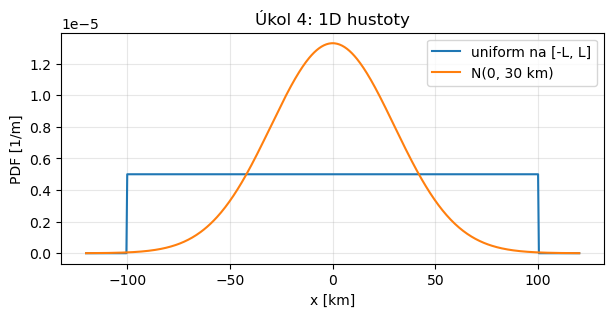

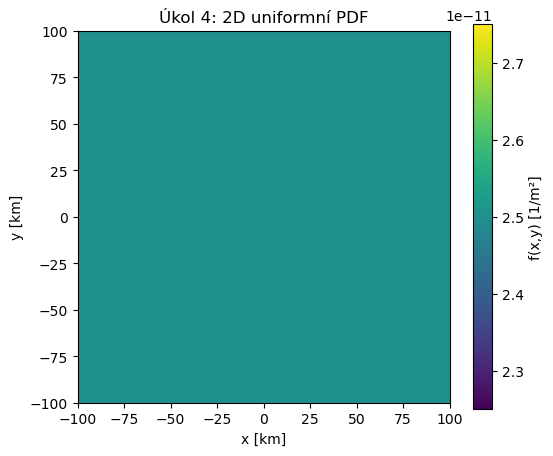

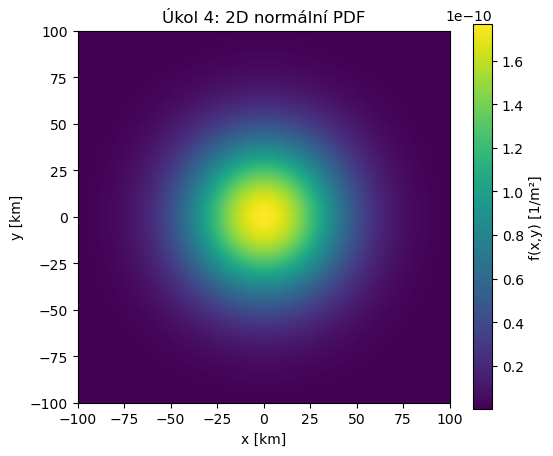

In [5]:
# Úkol 4 – řešení

###### doplňte kód zde ######
sigma_km = 30.0
sigma = sigma_km * 1000.0  # [m]

# 1D mřížka pro graf hustoty
x = np.linspace(-1.2 * L, 1.2 * L, 600)

# 1D uniformní: konstantní hustota na [-L, L]
pdf_uniform_1d = np.where(np.abs(x) <= L, 1.0 / (2.0 * L), 0.0)

# 1D normální N(0, sigma^2)
pdf_normal_1d = np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2.0 * np.pi))
#############################

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(x / 1000.0, pdf_uniform_1d, label="uniform na [-L, L]")
ax.plot(x / 1000.0, pdf_normal_1d, label=f"N(0, {sigma_km:.0f} km)")
ax.set(xlabel="x [km]", ylabel="PDF [1/m]", title="Úkol 4: 1D hustoty")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# 2D mřížka
grid_n = 160
xg, yg, XX, YY = make_grid(L, grid_n)

###### doplňte kód zde ######
# 2D uniformní: konstantní hustota na čtverci [-L, L]^2
pdf_uniform_2d = np.ones_like(XX) / ((2.0 * L) ** 2)

# 2D izotropní normální N(0, sigma^2 I)
pdf_normal_2d = np.exp(-0.5 * (XX * XX + YY * YY) / (sigma * sigma)) / (2.0 * np.pi * sigma * sigma)
#############################

show_map(pdf_uniform_2d, xg, yg, "Úkol 4: 2D uniformní PDF", "f(x,y) [1/m²]")
show_map(pdf_normal_2d, xg, yg, "Úkol 4: 2D normální PDF", "f(x,y) [1/m²]")


---
## 2.1. Věrohodnost (likelihood): model měření polohy trosky

Reálný svět je nejistý:

- drift je zjednodušený model,
- měření polohy (GPS, odhad z mapy, satelitní snímek) má chybu.

Zavedeme jednoduchý šum v poloze:

$$
y = G(u) + z,\qquad z \sim \mathcal{N}(0, \sigma^2 I).
$$

Pak je věrohodnost (2D izotropní gaussovo rozdělení) tvaru

$$
f_{Y\mid U}(y\mid u) = \frac{1}{2\pi\sigma^2}
\exp\!\left(-\frac{\|y-G(u)\|^2}{2\sigma^2}\right).
$$

Prakticky budeme počítat **logaritmus věrohodnosti (log-likelihood)**:

$$
\log f_{Y\mid U}(y\mid u)
= -\frac{\|y-G(u)\|^2}{2\sigma^2} - \log(2\pi\sigma^2).
$$

### Jak zvolit $\sigma$?

Aby věrohodnost nebyla „příliš ostrá“, necháme nejistotu růst s dobou driftu (v dnech):

$$
\sigma(\text{days}) = \sigma_0 + c\cdot \text{days}.
$$






---
### Úkol 5: Funkce pro $\sigma(\text{days})$ a logaritmus věrohodnosti

**Zadání:**
1. spočtěte $\sigma$ v metrech jako $\sigma(\text{days}) = \sigma_0 + c \cdot \text{days}$,
2. napište funkci `loglike_isotropic_gauss(...)` pro izotropní 2D gaussovu hustotu.

Parametry:
- $\sigma_0 = 100\,\mathrm{km}$,
- růst $c = 10\,\mathrm{km/den}$.

Tip: logaritmus věrohodnosti (log-likelihood) budeme chtít používat i pro celé mřížky (kde $G(u)$ vrací pole hodnot).


### Mini testy
**Testovací data** a očekávané hodnoty pro rychlou kontrolu správnosti.

**Test 1 – `sigma_days`**
- `days = [2, 10, 30]` (dny od 2 do 30)
- očekávané `sigma_m = [120000, 200000, 400000]`

**Test 2 – `loglike_isotropic_gauss` (shodné body)**
- `y_obs = [0, 0]`, `y_pred = [0, 0]`, `sigma_m = 2`
- očekávané `loglike = -ln(8π) ≈ -3.224171`

**Test 3 – `loglike_isotropic_gauss` (mřížka)**
- `y_obs = [0, 0]`, `y_pred_grid = ([0, 1], [0, 0])`, `sigma_m = 2`
- očekávané `loglike = [-3.224171, -3.349171]`





In [6]:
# Úkol 5 – řešení

def sigma_days(days, sigma0_km=100.0, growth_km_per_day=10.0):
    """Sigma v metrech jako lineární funkce doby driftu v dnech."""
    ###### doplňte kód zde ######
    sigma_km = sigma0_km + growth_km_per_day * days
    sigma_km = np.maximum(sigma_km, sigma0_km)  # jistota, že sigma neklesne pod sigma0
    sigma_m = sigma_km * 1000.0
    #############################
    return sigma_m

def loglike_isotropic_gauss(y_obs, y_pred, sigma_m):
    """Logaritmus věrohodnosti pro izotropní 2D gaussovo rozdělení: N(y_obs | y_pred, sigma^2 I).

    y_obs: array shape (2,)
    y_pred: array shape (2,) pro jeden bod
    sigma_m: skalár [m]
    """
    ###### doplňte kód zde ######
    # rozbalení predikce
    if isinstance(y_pred, tuple) or isinstance(y_pred, list):
        x_pred, y_pred_ = y_pred
    else:
        x_pred, y_pred_ = y_pred[0], y_pred[1]

    dx = y_obs[0] - x_pred
    dy = y_obs[1] - y_pred_
    r2 = dx * dx + dy * dy
    log_likelihood = -0.5 * r2 / (sigma_m * sigma_m) - np.log(2.0 * np.pi * sigma_m * sigma_m)
    #############################
    return log_likelihood



In [7]:
# Úkol 5 – mini testy - pro kontrolu správnosti
# Mini testovací data: jednoduché hodnoty s ručním očekáváním.
test_days = np.array([2.0, 10.0, 30.0])
expected_sigma_m = np.array([120000.0, 200000.0, 400000.0])
sigma_m = sigma_days(test_days)
print("sigma_days expected:", expected_sigma_m)
print("sigma_days computed:", sigma_m)
assert np.allclose(sigma_m, expected_sigma_m)

# loglike pro identické body
sigma_test = 2.0
y_obs = np.array([0.0, 0.0])
y_pred = np.array([0.0, 0.0])
ll0 = loglike_isotropic_gauss(y_obs, y_pred, sigma_test)
expected_ll0 = -np.log(2.0 * np.pi * sigma_test * sigma_test)
print("loglike expected (same point):", expected_ll0)
print("loglike computed (same point):", ll0)
assert np.isclose(ll0, expected_ll0)

# loglike pro vektorizovanou predikci (mřížka)
y_pred_grid = (np.array([0.0, 1.0]), np.array([0.0, 0.0]))
ll_grid = loglike_isotropic_gauss(y_obs, y_pred_grid, sigma_test)
expected_ll_grid = (-0.5 * (np.array([0.0, 1.0]) ** 2) / (sigma_test ** 2)
                   - np.log(2.0 * np.pi * sigma_test ** 2))
print("loglike expected (grid):", expected_ll_grid)
print("loglike computed (grid):", ll_grid)
assert np.allclose(ll_grid, expected_ll_grid)

print("Úkol 5 mini testy: OK")



sigma_days expected: [120000. 200000. 400000.]
sigma_days computed: [120000. 200000. 400000.]
loglike expected (same point): -3.224171427529236
loglike computed (same point): -3.224171427529236
loglike expected (grid): [-3.22417143 -3.34917143]
loglike computed (grid): [-3.22417143 -3.34917143]
Úkol 5 mini testy: OK


---
## 2.2. Posteriorní rozdělení na mřížce pro jednu trosku

Pro jednu trosku platí Bayesův vzorec:

$$
f_{U\mid Y}(u\mid y) \propto f_{Y\mid U}(y\mid u)\, f_U(u).
$$

Na mřížce budeme počítat v logaritmech:

- $\log f_U(u)$
- $\log f_{Y\mid U}(y\mid u)$
- $\log f_{U\mid Y}(u\mid y) = \log f_U(u) + \log f_{Y\mid U}(y\mid u)$

**MAP odhad** (maximum a posteriori) je bod s největší hodnotou posteriorního rozdělení na mřížce.








---
### Úkol 6: Priorní rozdělení, věrohodnost a posteriorní rozdělení pro 1 trosku

**Zadání:**
1. použijte uniformní priorní rozdělení na čtverci $[-L,L]^2$,
2. spočtěte forward mapy $G(u)$ pro 1 trosku,
3. spočtěte logaritmus věrohodnosti na mřížce,
4. spočtěte posteriorní rozdělení,
5. vykreslete:
   - prior,
   - relativní věrohodnost (pro zobrazení),
   - posteriorní rozdělení a body `u_true` a `u_map`.






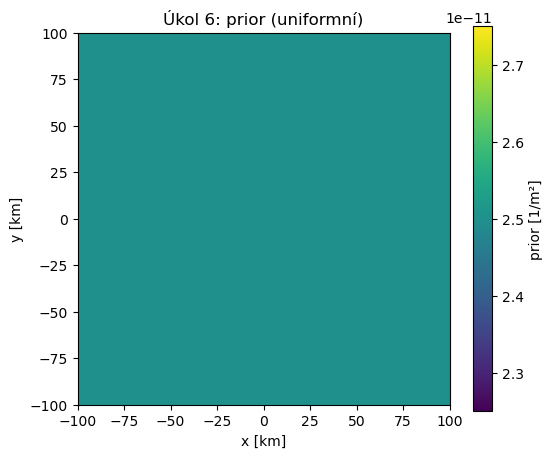

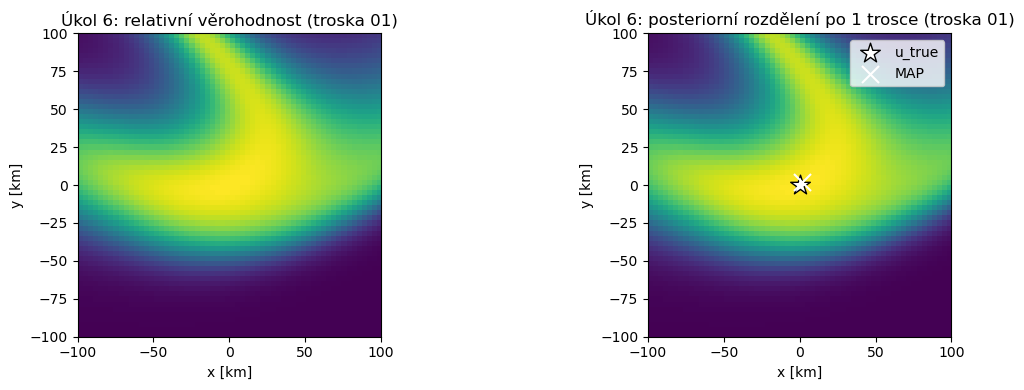

In [8]:
# Úkol 6 – řešení (1 troska)

# Mřížka pro bayesovský výpočet (zvolte menší kvůli času)
GRID_N = 60

# „Pravé“ místo havárie (zde záměrně jednoduché)
u_true = np.array([0.0, 0.0])  # [m]
t_crash_true = np.hypot(u_true[0], u_true[1]) / V  # [s]

# Doplnění parametrů T_drift a sigma pro zadanou trosku
obs = {"name": "troska 01", "kappa": 0.000232, "t_find": 24 * HOUR,  "y_obs": np.array([5,   259]) * 1000.0}
###### doplňte kód zde ######
obs["T_drift"] = obs["t_find"] - t_crash_true
days = obs["T_drift"] / DAY
obs["sigma"] = float(sigma_days(days))  # [m]
#############################

xg, yg, XX, YY = make_grid(L, GRID_N)

###### doplňte kód zde ######
# Čas havárie na mřížce
t_crash = np.hypot(XX, YY) / V

# Prior: uniformní na čtverci [-L, L]^2
prior = np.ones_like(XX) / ((2.0 * L) ** 2)

log_prior = np.log(prior + 0.0)  # +0.0 jen aby šlo jednoduše zkopírovat jako float


# Forward vyhodnocení: G(u) = (X_final(u), Y_final(u))
Xf, Yf = forward_grid_final(XX, YY, t_crash, obs["t_find"], obs["kappa"])

# Logaritmus věrohodnosti na mřížce
log_like = loglike_isotropic_gauss(obs["y_obs"], (Xf, Yf), obs["sigma"])

# Logaritmus posteriorního rozdělení
log_post = log_prior + log_like

# posteriorní rozdělení a věrohodnost
likelihood = np.exp(log_like)
posterior = np.exp(log_post)

# MAP na mřížce
j_map, i_map = np.unravel_index(np.argmax(posterior), posterior.shape)
u_map = np.array([xg[i_map], yg[j_map]])
##############################


# Vykreslení: prior, věrohodnost, posteriorní rozdělení
show_map(prior, xg, yg, "Úkol 6: prior (uniformní)", "prior [1/m²]")

show_like_post(likelihood, posterior, xg, yg,
    f"Úkol 6: relativní věrohodnost ({obs['name']})", f"Úkol 6: posteriorní rozdělení po 1 trosce ({obs['name']})",
    u_true, u_map)


---
# Finále - hledání letadla (syntetická úloha)

Abychom se soustředili na bayesovskou inverzi, použijeme **syntetická data**:

- zvolíme „pravé“ místo havárie $u_{\mathrm{true}}$,
- pro každou trosku spustíme dopředný model a vezmeme finální polohu jako pozorování $y_{\mathrm{obs}}$,
- ve věrohodnosti počítáme se šumem (aby posteriorní rozdělení nebylo numericky „nekonečně ostré“).

**Poznámka:** V reálné úloze $u_{\mathrm{true}}$ neznáme a máme jen pozorované body $y_{\mathrm{obs}}$ a časy nálezů.

V tomto cvičení jsou pozorování zadaná „ručně“ v tabulce (už v kilometrech). My je převedeme do metrů a připravíme datovou strukturu pro výpočty.


### Tabulka nálezů (vstupní data)
Hodnoty jsou zadány v kilometrech a hodinách (před převodem do SI).

| jméno | kappa [1/m] | t_find_h [h] | y_obs_km (x, y) |
| --- | ---: | ---: | --- |
| troska 01 | 0.000232 | 24  | (5, 259) |
| troska 02 | 0.001950 | 48  | (170, 629) |
| troska 03 | 0.000095 | 72  | (26, 1030) |
| troska 04 | 0.000615 | 96  | (-199, 1090) |
| troska 05 | 0.000053 | 120 | (-254, 1124) |
| troska 06 | 0.000348 | 144 | (-245, 1157) |
| troska 07 | 0.000033 | 168 | (-96, 744) |
| troska 08 | 0.000167 | 192 | (27, 1107) |
| troska 09 | 0.000072 | 216 | (61, 1168) |
| troska 10 | 0.000125 | 240 | (255, 1490) |





---
### Úkol 7: Načtení a vizualizace trosek

**Zadání:**
- připravte seznam trosek (jméno, $\kappa$, čas nálezu, pozorování),
- převeďte vše do SI jednotek (m, s),
- vykreslete pozorované polohy v rovině (v km),
- u každé trosky doplňte parametry `T_drift` a $\sigma$,
- pro kontrolu (protože jde o syntetickou úlohu) můžete vykreslit i trajektorie z $u_{\mathrm{true}}$.

**Poznámka:** Trajektorie umíme vykreslit jen proto, že tady „známe“ $u_{\mathrm{true}}$ (u reálných dat by to nebylo možné).

**Poznámka k zadání:** Data trosek z tabulky výše přepište do kódu (např. `observations`) – toto je **část k doplnění studentem**.





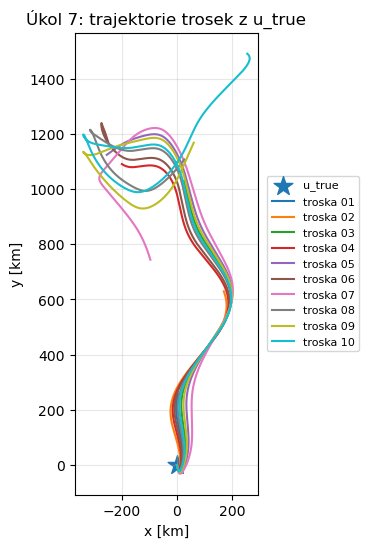

In [9]:
# Úkol 7 – řešení: syntetická data

###### doplňte kód zde ######
# „Pravé“ místo havárie (zde záměrně jednoduché)
u_true = np.array([0.0, 0.0])  # [m]

t_crash_true = np.hypot(u_true[0], u_true[1]) / V  # [s]

# Data z tabulky (v km a hodinách) zapsaná přímo do SI
observations = [
    {"name": "troska 01", "kappa": 0.000232, "t_find": 24 * HOUR,  "y_obs": np.array([5,   259]) * 1000.0},
    {"name": "troska 02", "kappa": 0.001950, "t_find": 48 * HOUR,  "y_obs": np.array([170, 629]) * 1000.0},
    {"name": "troska 03", "kappa": 0.000095, "t_find": 72 * HOUR,  "y_obs": np.array([26,  1030]) * 1000.0},
    {"name": "troska 04", "kappa": 0.000615, "t_find": 96 * HOUR,  "y_obs": np.array([-199,1090]) * 1000.0},
    {"name": "troska 05", "kappa": 0.000053, "t_find": 120 * HOUR, "y_obs": np.array([-254,1124]) * 1000.0},
    {"name": "troska 06", "kappa": 0.000348, "t_find": 144 * HOUR, "y_obs": np.array([-245,1157]) * 1000.0},
    {"name": "troska 07", "kappa": 0.000033, "t_find": 168 * HOUR, "y_obs": np.array([-96, 744]) * 1000.0},
    {"name": "troska 08", "kappa": 0.000167, "t_find": 192 * HOUR, "y_obs": np.array([27,  1107]) * 1000.0},
    {"name": "troska 09", "kappa": 0.000072, "t_find": 216 * HOUR, "y_obs": np.array([61,  1168]) * 1000.0},
    {"name": "troska 10", "kappa": 0.000125, "t_find": 240 * HOUR, "y_obs": np.array([255, 1490]) * 1000.0},
]
##############################

# Vykreslení trajektorií + doplnění pomocných hodnot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(u_true[0] / 1000.0, u_true[1] / 1000.0, marker="*", s=200, label="u_true")

for obs in observations:
    ###### doplňte kód zde ######
    obs["T_drift"] = obs["t_find"] - t_crash_true
    days = obs["T_drift"] / DAY
    obs["sigma"] = float(sigma_days(days))  # [m]
    t, r, v, a = simulate_drag_w_synthetic(u_true, t_crash_true, obs["kappa"], obs["T_drift"])
    #############################

    ax.plot(r[:, 0] / 1000.0, r[:, 1] / 1000.0, label=obs["name"])

ax.set(xlabel="x [km]", ylabel="y [km]", title="Úkol 7: trajektorie trosek z u_true")
ax.set_aspect("equal", "box")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.show()


---
## 3.1. Více trosek: nezávislé věrohodnosti a finální posteriorní rozdělení

Budeme předpokládat, že při daném $u$ jsou měření různých trosek **podmíněně nezávislá**:

$$
f(y^{(1)},\dots,y^{(K)}\mid u) = \prod_{k=1}^K f\left(y^{(k)}\mid u\right).
$$

V logaritmech tedy:

$$
\log f(y^{(1)},\dots,y^{(K)}\mid u) = \sum_{k=1}^K \log f\left(y^{(k)}\mid u\right).
$$

To je praktické, protože:

- součin mnoha malých čísel by numericky „podtekl“ k nule,
- v logaritmech jen sčítáme.

V následujícím úkolu budeme posteriorní rozdělení aktualizovat postupně:
po každé trosce zobrazíme její relativní věrohodnost a posteriorní rozdělení po dosavadních datech.







---
### Úkol 8: Posteriorní rozdělení pro více trosek

**Zadání:**
- začněte s `log_post = log_prior`,
- pro každou trosku:
  1. spočtěte forward mapy $(X_f, Y_f)$,
  2. spočtěte `log_like`,
  3. aktualizujte `log_post += log_like`,
  4. spočtěte a vykreslete:
     - věrohodnost dané trosky,
     - posteriorní rozdělení po dosavadních troskách.

Prakticky:
- kvůli času používejte menší `GRID_N`,
- pokud chcete opravdu jemné mapy, zvyšujte `GRID_N`, ale může to trvat déle.






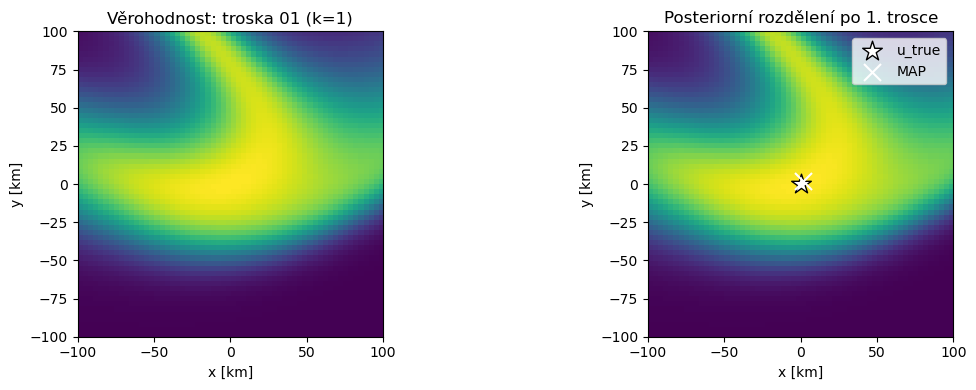

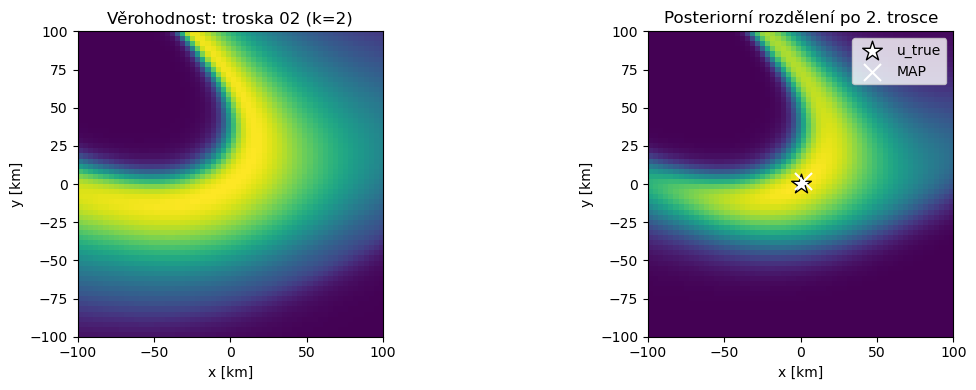

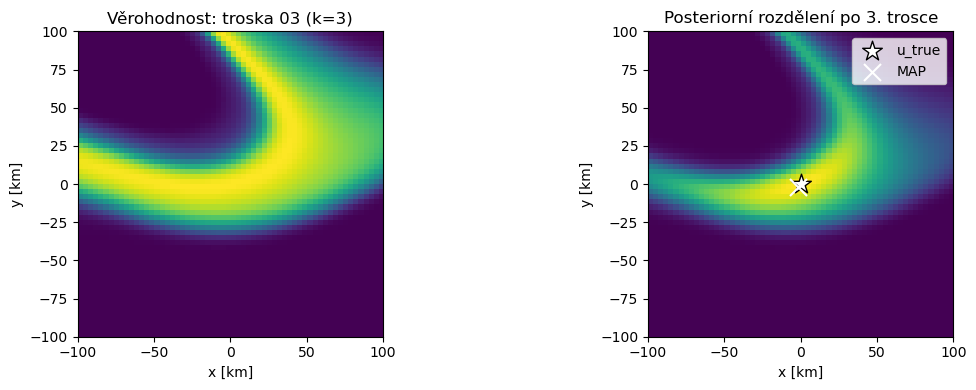

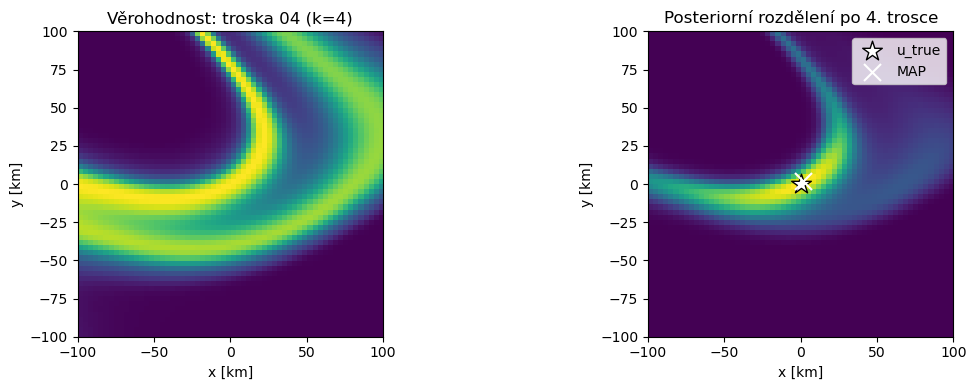

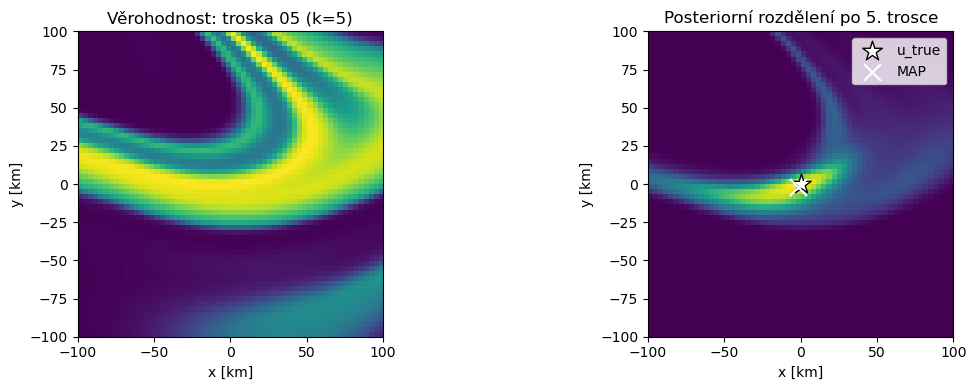

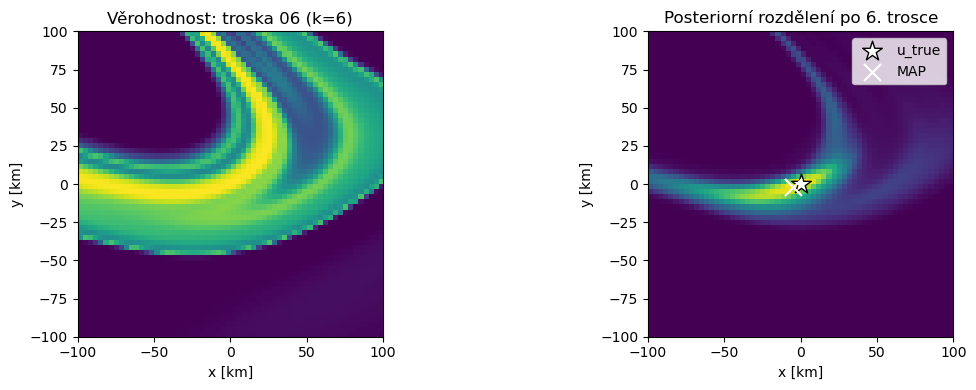

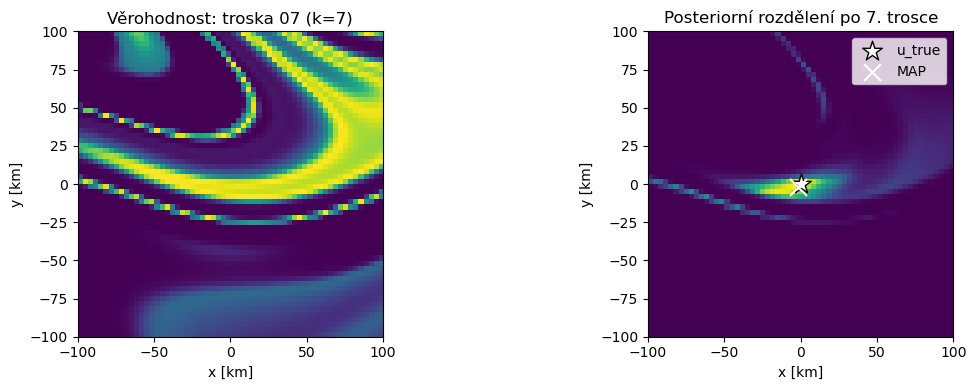

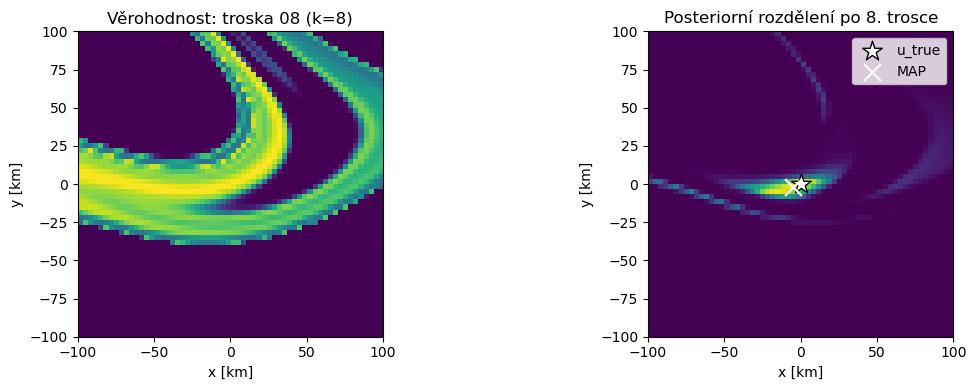

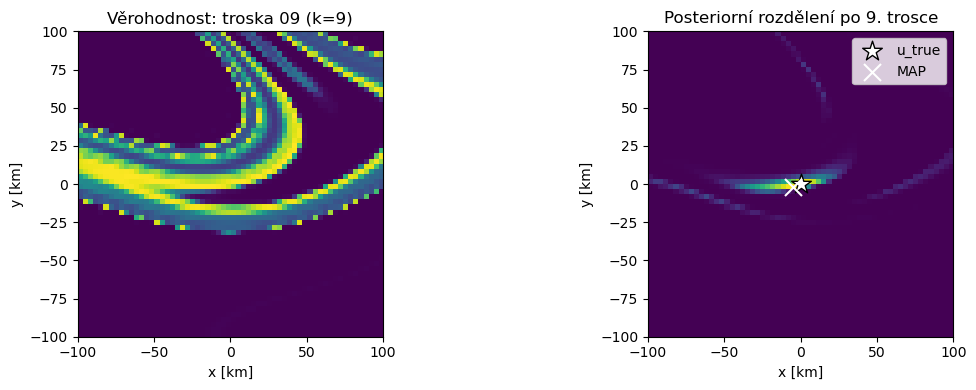

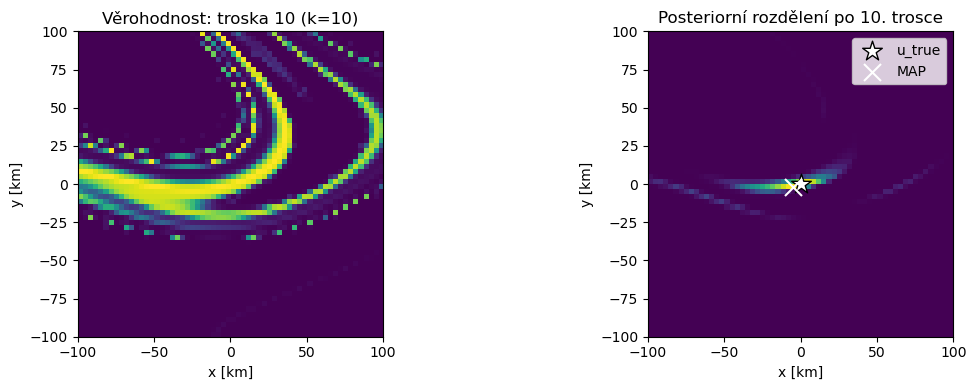

In [10]:
# Úkol 8 – řešení (více trosek)

GRID_N = 60
xg, yg, XX, YY = make_grid(L, GRID_N)
t_crash = np.hypot(XX, YY) / V

# Prior: uniformní na čtverci [-L, L]^2
prior = np.ones_like(XX) / ((2.0 * L) ** 2)

log_post = np.log(prior)

u_map = None

for k, obs in enumerate(observations, start=1):
    ###### doplňte kód zde ######
    # Forward
    Xf, Yf = forward_grid_final(XX, YY, t_crash, obs["t_find"], obs["kappa"])

    # Logaritmus věrohodnosti
    log_like = loglike_isotropic_gauss(obs["y_obs"], (Xf, Yf), obs["sigma"])

    # Aktualizace logaritmu posteriorního rozdělení
    log_post = log_post + log_like

    # Posteriorní rozdělení pro vykreslení
    posterior = np.exp(log_post)

    # MAP bod na mřížce
    j_map, i_map = np.unravel_index(np.argmax(posterior), posterior.shape)
    u_map = np.array([xg[i_map], yg[j_map]])

    # Věrohodnost
    likelihood = np.exp(log_like)

    ###########################

    # Vykreslení dvojice: věrohodnost + posteriorní rozdělení
    show_like_post(likelihood, posterior, xg, yg,
        f"Věrohodnost: {obs['name']} (k={k})", f"Posteriorní rozdělení po {k}. trosce",
        u_true, u_map)





